### What is the Treynor Ratio?
The Treynor Ratio measures the risk-adjusted return of a portfolio or stock, relative to its market risk (systematic risk) - i.e., beta, not total volatility.

"How much return am I earning above the risk-free rate for each unit of market risk (beta) I take?"

#### Why is the Treynor Ratio Important?
- It focuses on systematic risk (beta), which matters most for diversified portfolios.
- Useful for comparing performance of actively managed funds or stocks with different market exposures.
- While the Sharpe Ratio uses total risk (standard deviation), Treynor Ratio is cleaner for portfolios that are well-diversified, where unsystematic risk is minimized.

#### Treynor Ratio Formula

\begin{equation*}
\text { Treynor Ratio }=\frac{R_p-R_f}{\beta_p}
\end{equation*}


Where:
- $R_p$ : Average return of the asset/portfolio
- $R_f$ : Risk-free rate (e.g., $3 \%$ per annum)
- $\beta_p$ : Beta of the asset or portfolio (its sensitivity to market movement)

#### Interpretation:
- Higher Treynor ratio = Better risk-adjusted performance
- Positive ratio = Outperforming the risk-free rate
- Negative ratio = Underperforming the risk-free rate

#### Annualized Market Return Formula
To compute the annualized market return from daily returns, we use compounding to scale daily returns to a yearly value.
Formula:

\begin{equation*}
R_{\text {annual }}=\left(1+\bar{r}_{\text {daily }}\right)^{252}-1
\end{equation*}


Where:
- $\bar{r}_{\text {daily }}$ is the average daily return
- 252 is the number of trading days in a year
- $R_{\text {annual }}$ is the annualized return

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

In [3]:
# Step 1: Download data
end = dt.datetime.now()
start = end - dt.timedelta(days=365 * 5)
stocks = ["MSFT", "QQQ", "INTC", "SPY"]  # SPY is our market index
df = yf.download(stocks, start=start, end=end, auto_adjust=False)

# Step 2: Calculate daily returns
# Get adjusted close prices
adj_close = df['Adj Close']
daily_returns = adj_close.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed


In [20]:
# Step 3: Get risk-free rate (using 10-year Treasury as proxy)
# Download 10-year Treasury rate
treasury = yf.download("^TNX", start=start, end=end, auto_adjust=False )

# Check if treasury data was downloaded successfully
if treasury.empty:
    print("Warning: Could not fetch Treasury data. Using default risk-free rate of 4.5%")
    risk_free_rate = 0.045  # Default 4.5% annual rate
else:
    # Extract the scalar value properly
    risk_free_rate = float(treasury['Adj Close'].iloc[-1]) / 100  # Convert percentage to decimal

daily_risk_free_rate = risk_free_rate / 252  # Convert annual to daily

print(f"Current Risk-Free Rate (10Y Treasury): {risk_free_rate:.4f} ({risk_free_rate*100:.2f}%)")

[*********************100%***********************]  1 of 1 completed

Current Risk-Free Rate (10Y Treasury): 0.0443 (4.43%)



C:\Users\HP\AppData\Local\Temp\ipykernel_38240\3163930681.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  risk_free_rate = float(treasury['Adj Close'].iloc[-1]) / 100  # Convert percentage to decimal


In [27]:
# Step 4: Calculate beta for each stock against SPY (market index)
def calculate_beta(stock_returns, market_returns):
    """Calculate beta using covariance and variance"""
    covariance = np.cov(stock_returns, market_returns)[0][1]
    market_variance = np.var(market_returns)
    beta = covariance / market_variance
    return beta

In [28]:
# Step 5: Calculate Treynor Ratio
def calculate_treynor_ratio(stock_returns, market_returns, risk_free_rate):
    """Calculate Treynor Ratio for a stock"""
    # Calculate annualized returns
    stock_annual_return = (1 + stock_returns.mean()) ** 252 - 1
    
    # Calculate beta
    beta = calculate_beta(stock_returns, market_returns)
    
    # Calculate excess return
    excess_return = stock_annual_return - risk_free_rate
    
    # Calculate Treynor ratio
    if beta != 0:
        treynor_ratio = excess_return / beta
    else:
        treynor_ratio = np.inf  # Undefined if beta is 0
    
    return treynor_ratio, beta, stock_annual_return

In [29]:
# Step 6: Calculate Treynor ratios for all stocks
results = []
market_returns = daily_returns['SPY']

for stock in stocks:
    if stock != 'SPY':  # Don't calculate for the market index itself
        stock_returns = daily_returns[stock]
        
        # Remove any NaN values that might cause issues
        combined_data = pd.DataFrame({'stock': stock_returns, 'market': market_returns}).dropna()
        clean_stock_returns = combined_data['stock']
        clean_market_returns = combined_data['market']
        
        treynor_ratio, beta, annual_return = calculate_treynor_ratio(
            clean_stock_returns, clean_market_returns, risk_free_rate
        )
        
        results.append({
            'Stock': stock,
            'Annual Return': annual_return,
            'Beta': beta,
            'Treynor Ratio': treynor_ratio
        })

In [30]:
# Step 7: Create results DataFrame and display
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Treynor Ratio', ascending=False)

print("\n" + "="*60)
print("TREYNOR RATIO ANALYSIS RESULTS")
print("="*60)
print(f"Analysis Period: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")
print(f"Risk-Free Rate: {risk_free_rate*100:.2f}%")
print("-"*60)

for _, row in results_df.iterrows():
    print(f"Stock: {row['Stock']}")
    print(f"  Annual Return: {row['Annual Return']*100:.2f}%")
    print(f"  Beta: {row['Beta']:.3f}")
    print(f"  Treynor Ratio: {row['Treynor Ratio']:.4f}")
    print("-"*30)


TREYNOR RATIO ANALYSIS RESULTS
Analysis Period: 2020-05-29 to 2025-05-28
Risk-Free Rate: 4.43%
------------------------------------------------------------
Stock: MSFT
  Annual Return: 25.94%
  Beta: 1.168
  Treynor Ratio: 0.1842
------------------------------
Stock: QQQ
  Annual Return: 21.59%
  Beta: 1.236
  Treynor Ratio: 0.1388
------------------------------
Stock: INTC
  Annual Return: -10.12%
  Beta: 1.334
  Treynor Ratio: -0.1091
------------------------------


In [31]:
# Step 8: Interpretation
print("\nINTERPRETATION:")
print("-"*30)
best_stock = results_df.iloc[0]['Stock']
print(f"• Best Risk-Adjusted Performance: {best_stock}")
print(f"• Higher Treynor Ratio = Better risk-adjusted returns")
print(f"• Positive ratio = Outperforming risk-free rate")
print(f"• Beta > 1 = More volatile than market")
print(f"• Beta < 1 = Less volatile than market")

# Step 9: Additional analysis - Compare with market
market_annual_return = (1 + market_returns.mean()) ** 252 - 1
market_treynor = (market_annual_return - risk_free_rate) / 1.0  # Market beta = 1

print(f"\nMARKET BENCHMARK (SPY):")
print(f"• Annual Return: {market_annual_return*100:.2f}%")
print(f"• Beta: 1.000 (by definition)")
print(f"• Treynor Ratio: {market_treynor:.4f}")

print(f"\nSTOCKS OUTPERFORMING MARKET:")
outperforming = results_df[results_df['Treynor Ratio'] > market_treynor]
if not outperforming.empty:
    for _, row in outperforming.iterrows():
        print(f"• {row['Stock']}: {row['Treynor Ratio']:.4f}")
else:
    print("• None of the selected stocks outperformed the market on a risk-adjusted basis")


INTERPRETATION:
------------------------------
• Best Risk-Adjusted Performance: MSFT
• Higher Treynor Ratio = Better risk-adjusted returns
• Positive ratio = Outperforming risk-free rate
• Beta > 1 = More volatile than market
• Beta < 1 = Less volatile than market

MARKET BENCHMARK (SPY):
• Annual Return: 17.83%
• Beta: 1.000 (by definition)
• Treynor Ratio: 0.1340

STOCKS OUTPERFORMING MARKET:
• MSFT: 0.1842
• QQQ: 0.1388


In [34]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

# Step 1: Download data
end = dt.datetime.now()
start = end - dt.timedelta(days=365 * 5)

stocks = ["MSFT", "QQQ", "INTC", "SPY"]  # SPY is market index
df = yf.download(stocks, start=start, end=end, auto_adjust=False)["Adj Close"]

# Step 2: Calculate daily returns
daily_returns = df.pct_change().dropna()

# Step 3: Define risk-free rate
risk_free_rate = 0.03  # 3% annually
daily_rfr = risk_free_rate / 252

# Step 4: Calculate beta and Treynor ratio
treynor_data = {}

market_returns = daily_returns["SPY"]  # market = SPY

for stock in stocks:
    if stock == "SPY":
        continue  # skip market itself

    # Excess return
    stock_excess_return = daily_returns[stock] - daily_rfr
    avg_excess_return_annual = stock_excess_return.mean() * 252

    # Calculate Beta via covariance/variance
    covariance = np.cov(daily_returns[stock], market_returns)[0, 1]
    market_variance = np.var(market_returns)
    beta = covariance / market_variance

    # Treynor Ratio
    treynor_ratio = avg_excess_return_annual / beta

    treynor_data[stock] = {
        "Annual_Excess_Return_Pct": avg_excess_return_annual * 100,
        "Beta": beta,
        "Treynor_Ratio": treynor_ratio
    }

# Step 5: Display results
treynor_df = pd.DataFrame(treynor_data).T
print("\n" + "="*80)
print("TREYNOR RATIO ANALYSIS RESULTS")
print("="*80)

treynor_df_sorted = treynor_df.sort_values(by="Treynor_Ratio", ascending=False)

for stock in treynor_df_sorted.index:
    print(f"\n{stock}:")
    print(f"  Annual Excess Return: {treynor_df_sorted.loc[stock, 'Annual_Excess_Return_Pct']:.2f}%")
    print(f"  Beta:                 {treynor_df_sorted.loc[stock, 'Beta']:.4f}")
    print(f"  Treynor Ratio:        {treynor_df_sorted.loc[stock, 'Treynor_Ratio']:.4f}")


[*********************100%***********************]  4 of 4 completed


TREYNOR RATIO ANALYSIS RESULTS

MSFT:
  Annual Excess Return: 20.08%
  Beta:                 1.1676
  Treynor Ratio:        0.1720

QQQ:
  Annual Excess Return: 16.55%
  Beta:                 1.2361
  Treynor Ratio:        0.1339

INTC:
  Annual Excess Return: -13.67%
  Beta:                 1.3336
  Treynor Ratio:        -0.1025


### What is Jensen's Alpha?
Jensen's Alpha (or simply Alpha) measures the excess return of a stock or portfolio above what the Capital Asset Pricing Model (CAPM) predicts.

In simple terms:
"Given the stock's beta (market risk), did it perform better or worse than expected?"


### Why is Jensen's Alpha Important?

1. Risk-Adjusted Performance: Unlike simple returns, alpha accounts for the risk taken to achieve those returns
2. Manager Skill Assessment: Positive alpha suggests superior stock-picking ability or market timing
3. Benchmark Comparison: Shows whether a stock outperforms after adjusting for market risk
4. Investment Decision Tool: Helps identify undervalued (positive alpha) or overvalued (negative alpha) securities

### Jensen's Alpha Formula (CAPM-based)

\begin{equation*}
\alpha=R_p-\left[R_f+\beta_p\left(R_m-R_f\right)\right]
\end{equation*}


Where:
- $R_p$ : Annualized return of the stock/portfolio
- $R_f$ : Risk-free rate
- $\beta_p$ : Beta of the stock/portfolio
- $R_m$ : Annualized return of the market (e.g., SPY)
- The expression in brackets is the expected return via CAPM


### Interpretation
- Indicates stock selection skill or manager performance.
- If alpha > 0: the asset outperformed market expectations.
- If alpha < 0: the asset underperformed relative to risk taken.
- Often used by investors and analysts to assess whether a fund or stock added value beyond its market exposure.

In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

# Step 1: Download data
end = dt.datetime.now()
start = end - dt.timedelta(days=365 * 5)

stocks = ["MSFT", "QQQ", "INTC", "SPY"]  # SPY as market proxy
df = yf.download(stocks, start=start, end=end, auto_adjust=False)["Adj Close"]

# Step 2: Daily returns
daily_returns = df.pct_change().dropna()

# Step 3: Set risk-free rate (annual)
risk_free_rate = 0.03
daily_rfr = risk_free_rate / 252

# Step 4: Jensen’s Alpha computation
jensen_data = {}
market = "SPY"
market_returns = daily_returns[market]

# Annualized market return
market_annual_return = ((1 + market_returns.mean()) ** 252) - 1

for stock in stocks:
    if stock == market:
        continue

    stock_returns = daily_returns[stock]
    stock_annual_return = ((1 + stock_returns.mean()) ** 252) - 1

    # Calculate Beta: covariance(stock, market) / variance(market)
    beta = np.cov(stock_returns, market_returns)[0, 1] / np.var(market_returns)

    # Expected return from CAPM
    expected_return = risk_free_rate + beta * (market_annual_return - risk_free_rate)

    # Jensen’s Alpha
    alpha = stock_annual_return - expected_return

    jensen_data[stock] = {
        "Beta": beta,
        "Annual_Return_Pct": stock_annual_return * 100,
        "Expected_CAPM_Return_Pct": expected_return * 100,
        "Jensens_Alpha_Pct": alpha * 100
    }

# Step 5: Display results
jensen_df = pd.DataFrame(jensen_data).T

print("\n" + "="*80)
print("JENSEN'S ALPHA ANALYSIS RESULTS")
print("="*80)

jensen_df_sorted = jensen_df.sort_values(by="Jensens_Alpha_Pct", ascending=False)

for stock in jensen_df_sorted.index:
    print(f"\n{stock}:")
    print(f"  Beta:                        {jensen_df_sorted.loc[stock, 'Beta']:.4f}")
    print(f"  Annual Return:              {jensen_df_sorted.loc[stock, 'Annual_Return_Pct']:.2f}%")
    print(f"  Expected CAPM Return:       {jensen_df_sorted.loc[stock, 'Expected_CAPM_Return_Pct']:.2f}%")
    print(f"  Jensen's Alpha:             {jensen_df_sorted.loc[stock, 'Jensens_Alpha_Pct']:.2f}%")


[*********************100%***********************]  4 of 4 completed


JENSEN'S ALPHA ANALYSIS RESULTS

MSFT:
  Beta:                        1.1676
  Annual Return:              25.94%
  Expected CAPM Return:       20.32%
  Jensen's Alpha:             5.63%

QQQ:
  Beta:                        1.2361
  Annual Return:              21.59%
  Expected CAPM Return:       21.33%
  Jensen's Alpha:             0.26%

INTC:
  Beta:                        1.3336
  Annual Return:              -10.12%
  Expected CAPM Return:       22.78%
  Jensen's Alpha:             -32.90%


### Test

In [43]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from scipy import stats
import matplotlib.pyplot as plt

# Step 1: Download data
end = dt.datetime.now()
start = end - dt.timedelta(days=365 * 5)
stocks = ["MSFT", "QQQ", "INTC", "SPY"]  # SPY is our market index
df = yf.download(stocks, start=start, end=end, auto_adjust=False)

# Get the adjusted close prices
prices = df['Adj Close']

# Step 2: Calculate daily returns
returns = prices.pct_change().dropna()

# Step 3: Get risk-free rate (using 10-year Treasury as proxy)
# You can also use 3-month Treasury or any other risk-free benchmark
treasury = yf.download("^TNX", start=start, end=end, auto_adjust=False)
risk_free_annual = float(treasury['Adj Close'].iloc[-1]) / 100   # Convert percentage to decimal
risk_free_daily = risk_free_annual / 252  # Convert annual to daily (252 trading days)

print(f"Risk-free rate (annual): {risk_free_annual:.4f} ({risk_free_annual*100:.2f}%)")
print(f"Risk-free rate (daily): {risk_free_daily:.6f}")



[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed

Risk-free rate (annual): 0.0443 (4.43%)
Risk-free rate (daily): 0.000176



C:\Users\HP\AppData\Local\Temp\ipykernel_38240\50474964.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  risk_free_annual = float(treasury['Adj Close'].iloc[-1]) / 100   # Convert percentage to decimal


In [44]:
# Step 4: Define market benchmark (SPY)
market_returns = returns['SPY']
market_excess_returns = market_returns - risk_free_daily

def calculate_jensen_alpha(stock_returns, market_returns, risk_free_rate):
    """
    Calculate Jensen's Alpha using regression method
    
    Parameters:
    stock_returns: pandas Series of stock returns
    market_returns: pandas Series of market returns  
    risk_free_rate: float, daily risk-free rate
    
    Returns:
    dict with alpha, beta, r_squared, p_value, and other statistics
    """
    
    # Calculate excess returns
    stock_excess = stock_returns - risk_free_rate
    market_excess = market_returns - risk_free_rate
    
    # Remove any NaN values
    combined = pd.DataFrame({'stock': stock_excess, 'market': market_excess}).dropna()
    
    if len(combined) < 30:  # Need sufficient data points
        return None
    
    # Perform linear regression: stock_excess = alpha + beta * market_excess
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        combined['market'], combined['stock']
    )
    
    # In this regression:
    # intercept = Jensen's Alpha
    # slope = Beta
    alpha = intercept
    beta = slope
    r_squared = r_value ** 2
    
    # Calculate additional statistics
    stock_vol = combined['stock'].std() * np.sqrt(252)  # Annualized volatility
    market_vol = combined['market'].std() * np.sqrt(252)
    
    # Annualize alpha
    alpha_annual = alpha * 252
    
    # Calculate tracking error (standard deviation of excess returns difference)
    tracking_error = (combined['stock'] - combined['market']).std() * np.sqrt(252)
    
    # Information ratio (alpha / tracking error)
    info_ratio = alpha_annual / tracking_error if tracking_error != 0 else 0
    
    return {
        'alpha_daily': alpha,
        'alpha_annual': alpha_annual,
        'alpha_annual_pct': alpha_annual * 100,
        'beta': beta,
        'r_squared': r_squared,
        'p_value': p_value,
        'std_error': std_err,
        'stock_volatility': stock_vol,
        'tracking_error': tracking_error,
        'information_ratio': info_ratio,
        'observations': len(combined)
    }



In [45]:
# Step 5: Calculate Jensen's Alpha for each stock
print("\n" + "="*80)
print("JENSEN'S ALPHA ANALYSIS")
print("="*80)

results = {}
individual_stocks = [stock for stock in stocks if stock != 'SPY']

for stock in individual_stocks:
    print(f"\n{stock} Analysis:")
    print("-" * 40)
    
    stock_returns = returns[stock]
    result = calculate_jensen_alpha(stock_returns, market_returns, risk_free_daily)
    
    if result:
        results[stock] = result
        
        print(f"Jensen's Alpha (Annual): {result['alpha_annual_pct']:.2f}%")
        print(f"Beta: {result['beta']:.3f}")
        print(f"R-squared: {result['r_squared']:.3f}")
        print(f"P-value: {result['p_value']:.4f}")
        print(f"Tracking Error: {result['tracking_error']*100:.2f}%")
        print(f"Information Ratio: {result['information_ratio']:.3f}")
        print(f"Stock Volatility: {result['stock_volatility']*100:.2f}%")
        print(f"Observations: {result['observations']}")
        
        # Interpretation
        significance = "Significant" if result['p_value'] < 0.05 else "Not Significant"
        performance = "Outperformed" if result['alpha_annual'] > 0 else "Underperformed"
        
        print(f"\nInterpretation:")
        print(f"- {stock} {performance.lower()} the market by {abs(result['alpha_annual_pct']):.2f}% annually")
        print(f"- Alpha is {significance.lower()} (p-value: {result['p_value']:.4f})")
        print(f"- Beta of {result['beta']:.3f} means {stock} is {'more' if result['beta'] > 1 else 'less'} volatile than market")
        
    else:
        print(f"Insufficient data for {stock}")




JENSEN'S ALPHA ANALYSIS

MSFT Analysis:
----------------------------------------
Jensen's Alpha (Annual): 4.67%
Beta: 1.167
R-squared: 0.591
P-value: 0.0000
Tracking Error: 17.62%
Information Ratio: 0.265
Stock Volatility: 27.17%
Observations: 1254

Interpretation:
- MSFT outperformed the market by 4.67% annually
- Alpha is significant (p-value: 0.0000)
- Beta of 1.167 means MSFT is more volatile than market

QQQ Analysis:
----------------------------------------
Jensen's Alpha (Annual): 0.33%
Beta: 1.235
R-squared: 0.873
P-value: 0.0000
Tracking Error: 9.41%
Information Ratio: 0.035
Stock Volatility: 23.67%
Observations: 1254

Interpretation:
- QQQ outperformed the market by 0.33% annually
- Alpha is significant (p-value: 0.0000)
- Beta of 1.235 means QQQ is more volatile than market

INTC Analysis:
----------------------------------------
Jensen's Alpha (Annual): -31.06%
Beta: 1.333
R-squared: 0.304
P-value: 0.0000
Tracking Error: 36.60%
Information Ratio: -0.849
Stock Volatility: 4


SUMMARY COMPARISON

Ranking by Jensen's Alpha (Annual %):
1. MSFT: 4.67% (Beta: 1.167, Info Ratio: 0.265)
2. QQQ: 0.33% (Beta: 1.235, Info Ratio: 0.035)
3. INTC: -31.06% (Beta: 1.333, Info Ratio: -0.849)


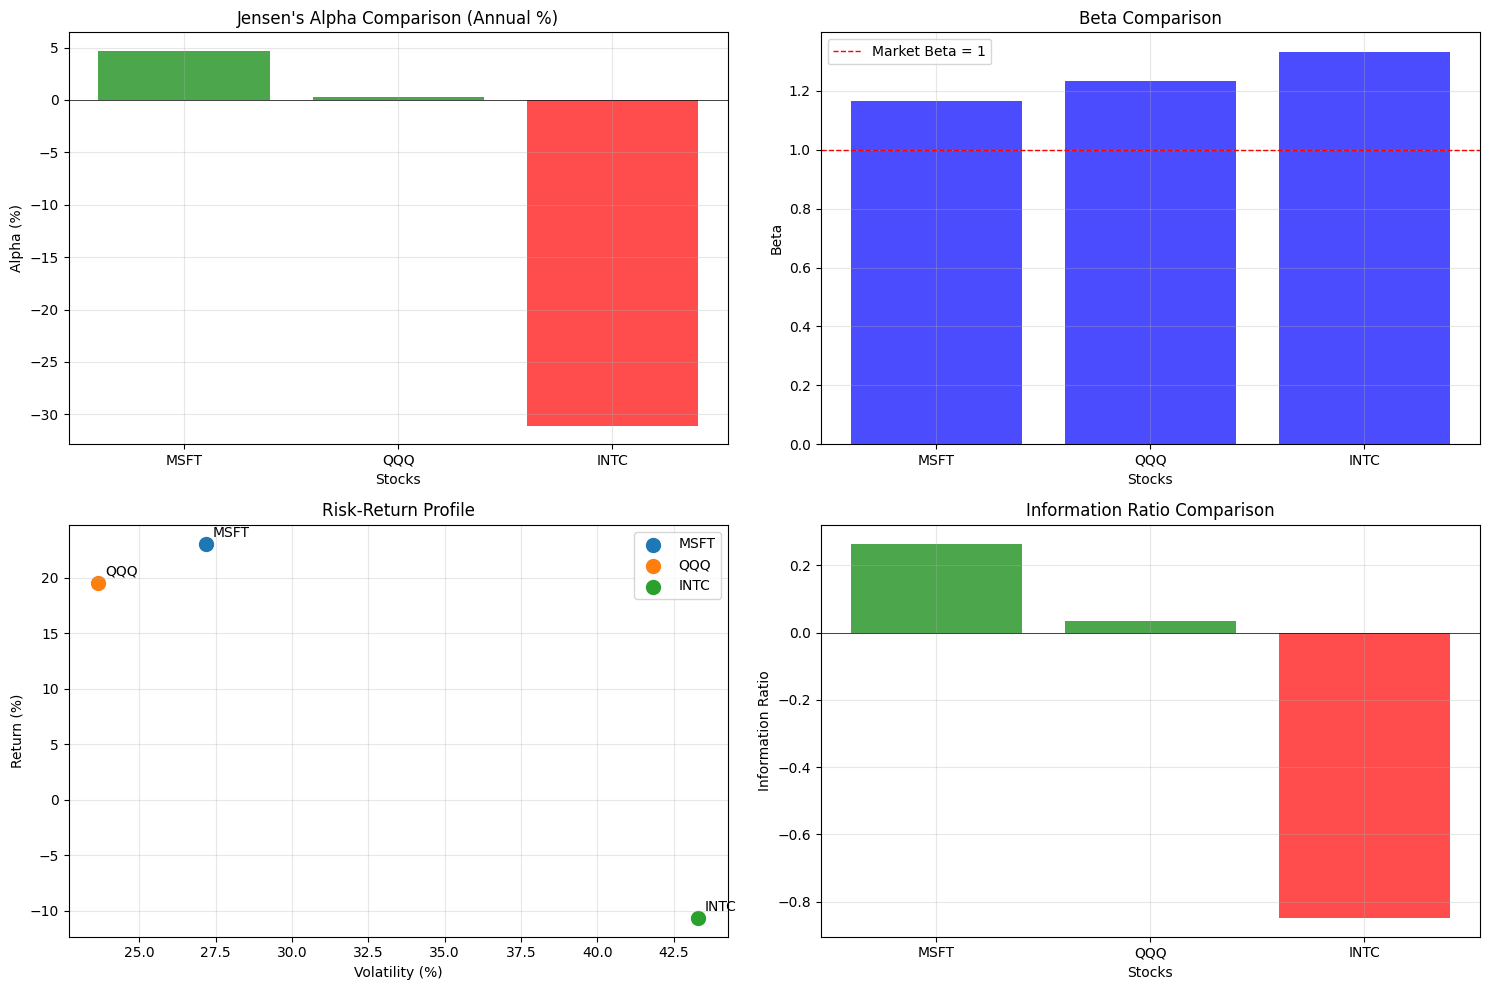


Results exported to 'jensen_alpha_results.csv'

Analysis Complete!


In [46]:
# Step 6: Summary comparison
print("\n" + "="*80)
print("SUMMARY COMPARISON")
print("="*80)

if results:
    summary_df = pd.DataFrame(results).T
    summary_df = summary_df.round(4)
    
    # Sort by alpha
    summary_df = summary_df.sort_values('alpha_annual_pct', ascending=False)
    
    print("\nRanking by Jensen's Alpha (Annual %):")
    for i, (stock, row) in enumerate(summary_df.iterrows(), 1):
        print(f"{i}. {stock}: {row['alpha_annual_pct']:.2f}% "
              f"(Beta: {row['beta']:.3f}, Info Ratio: {row['information_ratio']:.3f})")

# Step 7: Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Alpha comparison
plt.subplot(2, 2, 1)
alphas = [results[stock]['alpha_annual_pct'] for stock in individual_stocks if stock in results]
colors = ['green' if a > 0 else 'red' for a in alphas]
plt.bar(range(len(alphas)), alphas, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.title("Jensen's Alpha Comparison (Annual %)")
plt.xlabel("Stocks")
plt.ylabel("Alpha (%)")
plt.xticks(range(len(alphas)), [stock for stock in individual_stocks if stock in results])
plt.grid(True, alpha=0.3)

# Plot 2: Beta comparison  
plt.subplot(2, 2, 2)
betas = [results[stock]['beta'] for stock in individual_stocks if stock in results]
plt.bar(range(len(betas)), betas, color='blue', alpha=0.7)
plt.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Market Beta = 1')
plt.title("Beta Comparison")
plt.xlabel("Stocks")
plt.ylabel("Beta")
plt.xticks(range(len(betas)), [stock for stock in individual_stocks if stock in results])
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Risk-Return scatter
plt.subplot(2, 2, 3)
for stock in individual_stocks:
    if stock in results:
        x = results[stock]['stock_volatility'] * 100
        y = (returns[stock].mean() * 252) * 100  # Annualized return
        plt.scatter(x, y, s=100, label=stock)
        plt.annotate(stock, (x, y), xytext=(5, 5), textcoords='offset points')

plt.xlabel("Volatility (%)")
plt.ylabel("Return (%)")
plt.title("Risk-Return Profile")
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 4: Information Ratio
plt.subplot(2, 2, 4)
info_ratios = [results[stock]['information_ratio'] for stock in individual_stocks if stock in results]
colors = ['green' if ir > 0 else 'red' for ir in info_ratios]
plt.bar(range(len(info_ratios)), info_ratios, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.title("Information Ratio Comparison")
plt.xlabel("Stocks")
plt.ylabel("Information Ratio")
plt.xticks(range(len(info_ratios)), [stock for stock in individual_stocks if stock in results])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 8: Export results to CSV
if results:
    summary_df.to_csv('jensen_alpha_results.csv')
    print(f"\nResults exported to 'jensen_alpha_results.csv'")
    
print("\nAnalysis Complete!")